# Modeling

In [1]:
import pandas as pd
from datetime import timedelta

#### Import data

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

In [4]:
toy_products_df.shape

(3125, 6)

In [5]:
toy_dataset_df.shape

(32151, 23)

#### Clean data

In [6]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

In [54]:
toy_dataset_df = toy_dataset_df[toy_dataset_df['point_of_sales']=='Online Store']

In [55]:
toy_dataset_df.shape

(29338, 25)

#### Create train, test data sets based on date split

In [56]:
split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [57]:
test_dates = test['timestamp'].dt.date.unique().tolist()
len(test_dates)

230

In [106]:
train_dates = train['timestamp'].dt.date.unique().tolist()
len(train_dates)

894

In [58]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

81.98

In [231]:
print(train.shape)
print(test.shape)

(24050, 25)
(5288, 25)


### Baseline Model - top 10 titles over previous week

In [60]:
def get_top10_title_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'title_rank']
    return top10_last_wk_df

In [61]:
get_top10_title_preds(as_of_dt='2021-08-13')

,title_pred,prev_wk_cnt,transaction_date,title_rank
4,Olympic Running,64,2021-08-13,1.0
2,Iron Running,31,2021-08-13,2.0
8,Vanguard Sandal,12,2021-08-13,3.0
0,Classic Sneaker,9,2021-08-13,4.0
1,Hustler Boot,9,2021-08-13,5.0
3,League Running,8,2021-08-13,6.0
5,Rogue Sneaker,8,2021-08-13,7.0
6,Scalar Sandal,4,2021-08-13,8.0
7,Stacked Hiking Boot,2,2021-08-13,9.0


In [62]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','title_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [63]:
assert full_eval_df.shape[0] == test.shape[0]

In [64]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,product_title_gender,rating,title_pred,title_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,30908.0,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running-Kids,1,Olympic Running,1.0
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,75068.0,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running-Men,1,Olympic Running,1.0
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Men,1,Iron Running,3.0
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Women,1,Iron Running,3.0
4,10892,2022-05-22 06:00:00,13099258178146683672,5081644438403400480,266.0,Iron Running,Dartmouth Green,Men,Running,11.0,...,42759.0,6585.0,72274.0,88910.0,66.4,6.9,Iron Running-Men,1,Iron Running,3.0


In [65]:
# Percent of test purchases that were in top 10
full_eval_df['title_rank'].count() / full_eval_df.shape[0]

0.9517776096822995

In [66]:
# average rec rank of purchases that fell in top 10
full_eval_df['title_rank'].mean()

3.7264057222332605

<AxesSubplot:>

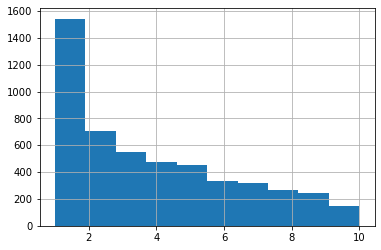

In [67]:
full_eval_df['title_rank'].hist()

### Baseline model - top 10 title-gender products over previous week

In [68]:
def get_top10_title_gender_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular title-gender products sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & 
                                  (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby(['product_title', 'product_gender']).size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'gender_pred', 'prev_wk_cnt', 'pred_rank']
    top10_last_wk_df['transaction_date'] = as_of_dt
    return top10_last_wk_df

In [69]:
get_top10_title_gender_preds(as_of_dt = '2022-08-13', prev_days=7, top_n=10)

,title_pred,gender_pred,prev_wk_cnt,pred_rank,transaction_date
13,Olympic Running,Women,26,1.0,2022-08-13
8,League Running,Women,16,2.0,2022-08-13
0,Bejeweled Boot,Unisex,15,3.0,2022-08-13
6,Iron Running,Women,15,4.0,2022-08-13
4,Hustler Boot,Women,12,5.0,2022-08-13
14,Olympic Running,Youth,8,6.0,2022-08-13
10,Marathon Running,Women,8,7.0,2022-08-13
21,Stacked Hiking Boot,Women,7,8.0,2022-08-13
17,Rogue Sneaker,Women,7,9.0,2022-08-13
5,Iron Running,Men,7,10.0,2022-08-13


In [70]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [71]:
assert full_eval_df.shape[0] == test.shape[0]

In [72]:
# Percent of test purchases that were in top 10
full_eval_df['pred_rank'].count() / full_eval_df.shape[0]

0.6348335854765507

In [73]:
# average rec rank of purchases that fell in top 10
full_eval_df['pred_rank'].mean()

4.207625856419422

<AxesSubplot:>

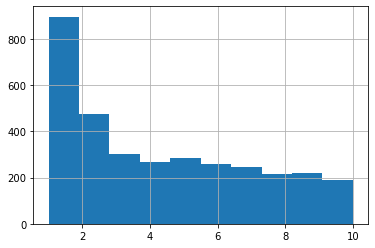

In [74]:
full_eval_df['pred_rank'].hist()

In [75]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,product_title_gender,rating,title_pred,gender_pred,pred_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running-Kids,1,NaN,NaN,NaN
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running-Men,1,NaN,NaN,NaN
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Men,1,NaN,NaN,NaN
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Women,1,Iron Running,Women,3.0
4,10892,2022-05-22 06:00:00,13099258178146683672,5081644438403400480,266.0,Iron Running,Dartmouth Green,Men,Running,11.0,...,6585.0,72274.0,88910.0,66.4,6.9,Iron Running-Men,1,NaN,NaN,NaN


In [78]:
# create title-gender field
toy_dataset_df.loc[:,'product_title_gender'] = toy_dataset_df['product_title'] + '-' + toy_dataset_df['product_gender']

### Collaborative Filtering

In [29]:
train.columns

Index(['Unnamed: 0', 'timestamp', 'transaction_id', 'hash_customer',
       'sale_amount', 'product_title', 'product_color', 'product_gender',
       'product_category', 'product_size', 'referrer_source', 'point_of_sales',
       'zip_tot_hh', 'zip_avg_hh_size', 'zip_avg_fam_size', 'zip_med_age',
       'zip_male_female_ratio', 'zip_tot_pop', 'zip_tot_white_nh',
       'zip_med_hh_income', 'zip_mean_hh_income', 'zip_pct_emp_lf',
       'zip_unemp_rate'],
      dtype='object')

In [31]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split

In [82]:
# Add a binary rating column
# toy_dataset_df.loc[:,"rating"] = 1

In [83]:
# Define the Reader object
reader = Reader(rating_scale=(0, 1))

In [ ]:
# cf_train_data_set = toy_dataset_df.groupby(['hash_customer', 'product_title_gender']).size().reset_index(name='count')

In [84]:
# Load the data into the Surprise dataset format
data = Dataset.load_from_df(toy_dataset_df[["hash_customer", "product_title_gender", "rating"]], reader)

In [85]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [86]:
# Define the algorithm
sim_options = {"name": "cosine", "user_based": False}
algo = KNNBasic(sim_options=sim_options)

In [87]:
# Train the model on the training set
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [88]:
# Test the model on the test set
predictions = algo.test(testset)

In [89]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [90]:
top_n

{8275062546790707801: ['Olympic Running-Women'],
 7453143749300234379: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Classic Sneaker-Women',
  'Olympic Running-Women',
  'Rogue Sneaker-Women',
  'Classic Sneaker-Women',
  'Scalar Sandal-Women',
  'Olympic Running-Women'],
 6280921628500077617: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 934772523603658765: ['Hustler Boot-Men',
  'Corner Sandal-Unisex',
  'Vanguard Sandal-Men',
  'Corner Sandal-Unisex',
  'Marathon Running-Men',
  'Corner Sandal-Unisex',
  'Training Sneaker-Men',
  'Iron Running-Men',
  'Olympic Running-Women',
  'Marathon Running-Men'],
 14711778386631295359: ['League Running-Men'],
 3088306778024088919: ['Olympic Running-Women',
  'Olympic Running-Kids',
  'Olympic Running-Youth',
  'League Running-Women'],
 1311068505070111502: ['Rogue Sneaker-Men'],
 168847860845

In [93]:
from surprise import SVD

In [94]:
# Define the algorithm
algo = SVD(verbose=True, n_epochs=10)

# Train the model on the training set
algo.fit(trainset)

# Test the model on the test set
predictions = algo.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [100]:
from surprise.model_selection import cross_validate

In [101]:
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [102]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [103]:
top_n

{8275062546790707801: ['Olympic Running-Women'],
 7453143749300234379: ['Classic Sneaker-Women',
  'Rogue Sneaker-Women',
  'Classic Sneaker-Women',
  'Classic Sneaker-Women',
  'Classic Sneaker-Women',
  'Rogue Sneaker-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 6280921628500077617: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 934772523603658765: ['Corner Sandal-Unisex',
  'Corner Sandal-Unisex',
  'Marathon Running-Men',
  'Corner Sandal-Unisex',
  'Iron Running-Men',
  'Marathon Running-Men',
  'Marathon Running-Men',
  'Hustler Boot-Women',
  'Olympic Running-Women',
  'Hustler Boot-Men'],
 14711778386631295359: ['League Running-Men'],
 3088306778024088919: ['Olympic Running-Kids',
  'Olympic Running-Youth',
  'League Running-Women',
  'Olympic Running-Women'],
 1311068505070111502: ['Rogue Sneaker-Men'],
 1688478608458

## Binary classifier

In [105]:
import random

In [232]:
train.columns

Index(['Unnamed: 0', 'timestamp', 'transaction_id', 'hash_customer',
       'sale_amount', 'product_title', 'product_color', 'product_gender',
       'product_category', 'product_size', 'referrer_source', 'point_of_sales',
       'zip_tot_hh', 'zip_avg_hh_size', 'zip_avg_fam_size', 'zip_med_age',
       'zip_male_female_ratio', 'zip_tot_pop', 'zip_tot_white_nh',
       'zip_med_hh_income', 'zip_mean_hh_income', 'zip_pct_emp_lf',
       'zip_unemp_rate', 'product_title_gender', 'rating'],
      dtype='object')

#### Create training data set

In [233]:
positive_samples = train[['timestamp', 'transaction_id', 'hash_customer', 
                          'sale_amount', 'product_title', 'product_color', 'product_gender',
                          'product_category', 'referrer_source']]

In [234]:
genders = train['product_gender'].unique()
genders

array(['Women', 'Men', 'Kids', 'Youth', 'Unisex'], dtype=object)

In [235]:
colors = train['product_color'].unique()
colors

array(['Midnight Green (Eagle Green)', 'Prussian Blue', 'Electric Purple',
       'Stormcloud', 'Vermilion (Plochere)', 'Topaz', 'Royal Blue (Web)',
       'Lavender Purple', 'Han Purple', 'Burnt Sienna', 'Green (Munsell)',
       'Dark Red', 'Electric Green', 'Fern Green', 'Ruby Red',
       'Mikado Yellow', 'Pastel Magenta', 'Canary Yellow',
       'Dartmouth Green', 'Dark Powder Blue', 'Alice Blue',
       'Mordant Red 19', 'Sky Blue', 'Yellow-Green', 'Selective Yellow'],
      dtype=object)

In [239]:
positive_samples.loc[:,'purchase'] = 1

In [240]:
positive_samples.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1
2,2019-10-18 06:00:00,5418521222138237582,15372924648196696535,141.0,Rogue Sneaker,Electric Purple,Women,Sneaker,Direct,1
3,2021-10-03 19:00:00,13807911046559617059,15372924648196696535,147.0,Classic Sneaker,Electric Purple,Women,Sneaker,Direct,1
4,2019-10-18 09:00:00,17285359619674932653,10040016928726048703,194.0,Olympic Running,Stormcloud,Women,Running,Search,1


In [241]:
%%time

NUM_NEGATIVE_SAMPLES = 3

train_df = pd.DataFrame()

# loop through dates
for idx, dt, in enumerate(positive_samples['timestamp'].dt.date.unique()[0:20]):
    print(dt, end=',')
    
    # subset purchases by date
    purchases = positive_samples[positive_samples['timestamp'].dt.date == dt]
    
    all_negative_samples = pd.DataFrame()
    # loop over purchases
    for idx, row in purchases.iterrows():
        # create negative_samples
        dfs = [row.to_frame().T for i in range(NUM_NEGATIVE_SAMPLES)]
        negative_samples = pd.concat(dfs, ignore_index=True)
        negative_samples['purchase'] = 0
        negative_samples['product_gender'] = negative_samples['product_gender'].apply(lambda x: random.choice(genders))
        negative_samples['product_color'] = negative_samples['product_color'].apply(lambda x: random.choice(colors))
        # sale_amount, title, category
        sample_product = train[['sale_amount', 'product_title', 'product_category']].sample(NUM_NEGATIVE_SAMPLES)
        negative_samples['sale_amount'] = sample_product['sale_amount'].values
        negative_samples['product_title'] = sample_product['product_title'].values
        negative_samples['product_category'] = sample_product['product_category'].values
        all_negative_samples = pd.concat([all_negative_samples, negative_samples])
    
    train_df = pd.concat([train_df, purchases])
    train_df = pd.concat([train_df, all_negative_samples])
    print(train_df.shape[0], end=',')

2019-10-17,4,2022-03-26,104,2019-10-18,124,2021-10-03,236,2021-06-23,444,2021-04-27,540,2022-03-03,624,2021-11-30,5496,2019-10-20,5512,2019-12-19,5568,2021-05-20,5696,2021-10-13,5820,2019-10-21,5852,2020-08-09,5936,2021-06-11,6112,2022-01-26,6248,2022-03-09,11492,2019-11-18,11548,2021-11-27,13056,2021-06-06,13148,Wall time: 30.2 s


In [242]:
import random

In [243]:
# training data records
train_df.shape[0]

13148

In [244]:
train_df['purchase'].value_counts()

0    9861
1    3287
Name: purchase, dtype: int64

In [245]:
sample_product = train[['sale_amount', 'product_title', 'product_category']].sample(5)

In [246]:
sample_product

,sale_amount,product_title,product_category
7282,198.0,Iron Running,Running
20499,198.0,Rogue Sneaker,Sneaker
13328,111.0,Hustler Boot,Boot
2396,141.0,Rogue Sneaker,Sneaker
8223,194.0,Olympic Running,Running


In [247]:
negative_samples['sale_amount'] = sample_product['sale_amount']

In [248]:
negative_samples

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2021-06-06 19:00:00,12360027504016356009,17021300559605301669,NaN,Olympic Running,Yellow-Green,Unisex,Running,Direct,0
1,2021-06-06 19:00:00,12360027504016356009,17021300559605301669,NaN,Vanguard Sandal,Dark Red,Youth,Sandal,Direct,0
2,2021-06-06 19:00:00,12360027504016356009,17021300559605301669,NaN,League Running,Prussian Blue,Men,Running,Direct,0


In [249]:
train_df[train_df['transaction_id']==1544787530173934449].head(50)

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
29558,2021-06-23 14:00:00,1544787530173934449,527593151349771214,194.0,Olympic Running,Topaz,Women,Running,Direct,1
0,2021-06-23 14:00:00,1544787530173934449,527593151349771214,147.0,Classic Sneaker,Electric Purple,Kids,Sneaker,Direct,0
1,2021-06-23 14:00:00,1544787530173934449,527593151349771214,194.0,Olympic Running,Lavender Purple,Men,Running,Direct,0
2,2021-06-23 14:00:00,1544787530173934449,527593151349771214,194.0,League Running,Royal Blue (Web),Kids,Running,Direct,0


In [125]:
positive_samples[positive_samples['hash_customer']==118171218419602151]

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1


In [229]:
train_df[train_df['hash_customer']==118171218419602151].head(50)

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,266.0,Iron Running,Han Purple,Women,Running,Direct,0
1,2019-10-17 17:00:00,13964574791861793493,118171218419602151,198.0,Iron Running,Prussian Blue,Men,Running,Direct,0
2,2019-10-17 17:00:00,13964574791861793493,118171218419602151,147.0,Classic Sneaker,Electric Green,Women,Sneaker,Direct,0
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1
0,2022-03-26 04:00:00,15462755904385104185,118171218419602151,198.0,Iron Running,Topaz,Unisex,Running,Direct,0
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,275.0,Iron Running,Vermilion (Plochere),Kids,Running,Direct,0
2,2022-03-26 04:00:00,15462755904385104185,118171218419602151,111.0,Hustler Boot,Alice Blue,Unisex,Boot,Direct,0


In [228]:
train_df.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,266.0,Iron Running,Han Purple,Women,Running,Direct,0
1,2019-10-17 17:00:00,13964574791861793493,118171218419602151,198.0,Iron Running,Prussian Blue,Men,Running,Direct,0
2,2019-10-17 17:00:00,13964574791861793493,118171218419602151,147.0,Classic Sneaker,Electric Green,Women,Sneaker,Direct,0
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1


In [ ]:
def add_user_features(df):
    """ 
    Function to add user_features to train/test dataframes
    Returns input dataframe with additional fields for user features
    """
    # add filter to groupby statement to only include transactions that occurred before the event
    user_agg = df[df['purchase_date'] < train_df['event_date'].min()].groupby('user_id').agg({
        'purchase_amount': ['sum', 'count']
    })
    

In [265]:
user_data = train_df[train_df['timestamp'].dt.date<pd.to_datetime('2022-03-26')]

In [267]:
user_data.dtypes

timestamp           datetime64[ns]
transaction_id              object
hash_customer               object
sale_amount                float64
product_title               object
product_color               object
product_gender              object
product_category            object
referrer_source             object
purchase                     int64
dtype: object

In [269]:
user_agg_features = user_data.groupby('hash_customer').agg({
    'product_title': ['nunique', 'count'],
    'transaction_id': ['nunique', 'count'],
    'sale_amount': ['sum', 'mean']
})

In [295]:
# loop through dates
train_df_w_user_features = pd.DataFrame()
for idx, dt, in enumerate(train_df['timestamp'].dt.date.unique()[0:2]):
    print(dt, end=',')
    
    # select the subset of the training data set for the current user and events prior to the transaction date
    hist_data = train[(train['timestamp'].dt.date < dt)]
    
    print(hist_data.shape)
    if hist_data.shape[0] > 0:

        # compute user-level features for the subset of data
        user_agg_features = hist_data.groupby('hash_customer').agg({
            'product_title': ['nunique', 'count'],
            'transaction_id': ['nunique', 'count'],
            'sale_amount': ['sum', 'mean']
        })

        # flatten column names
        user_agg_features.columns = ['_user_'.join(col).strip() for col in user_agg_features.columns.values]
        user_agg_features.reset_index()
        
        df_w_features = pd.merge(left=train_df[train_df['timestamp'].dt.date == dt], 
                                right=user_agg_features,
                                left_on='hash_customer',
                                right_on='hash_customer', 
                                how='left')
        train_df_w_user_features = pd.concat([train_df_w_user_features, df_w_features])

2019-10-17,(1, 25)
2022-03-26,(23852, 25)


In [296]:
user_data_w_features = pd.merge(left=train_df, 
                                right=user_agg_features.reset_index(),
                                left_on='hash_customer',
                                right_on='hash_customer', 
                                how='left')

In [299]:
train_df_w_user_features.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase,product_title_user_nunique,product_title_user_count,transaction_id_user_nunique,transaction_id_user_count,sale_amount_user_sum,sale_amount_user_mean
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-10-17 17:00:00,13964574791861793493,118171218419602151,224.0,League Running,Yellow-Green,Unisex,Running,Direct,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-10-17 17:00:00,13964574791861793493,118171218419602151,198.0,Iron Running,Electric Green,Women,Running,Direct,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-10-17 17:00:00,13964574791861793493,118171218419602151,224.0,Olympic Running,Prussian Blue,Men,Running,Direct,0,NaN,NaN,NaN,NaN,NaN,NaN
0,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1,1.0,1.0,1.0,1.0,141.0,141.0


In [298]:
train_df[train_df['timestamp'].dt.date == '2022-03-26']

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase


In [287]:
train[train['hash_customer']==118171218419602151]

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_med_age,zip_male_female_ratio,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,product_title_gender,rating
0,10,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,11.0,...,56.9,109.0,27226.0,21301.0,73818.0,122494.0,54.7,5.6,Rogue Sneaker-Women,1
1,11,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,11.0,...,56.9,109.0,27226.0,21301.0,73818.0,122494.0,54.7,5.6,Vanguard Sandal-Women,1


In [292]:
df_w_features.shape

(100, 16)